### 02 – BTC Simulator: QED Diffusion + Hawkes Jumps

In this notebook you will build a simple BTC price simulator combining:

1. **QED-style nonlinear diffusion** (continuous component)  
2. **Hawkes-driven jump process** (discrete component)

Then you will **calibrate** the parameters using the stylized facts observed in Notebook 01, and finally **validate** that the simulated data qualitatively resembles real BTC behaviour.

This simulator will serve as the pricing environment for:
- the option layer (Notebook 03),
- the market-making strategy (Notebook 04),
- and the RL hedging agent (Notebook 05–07).


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from pathlib import Path
import random
import torch

plt.style.use("ggplot")

def set_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

set_seeds(42)

# Load 5-min raw data
data_path = Path('/Users/jknight/Desktop/金融数学/take-home task/BTC_5m.csv')
df_5m = pd.read_csv(data_path, parse_dates=['datetime'])
df_5m.head()


/var/folders/4n/pzfc0pf10c71brsmm9q_fn8r0000gn/T/ipykernel_96067/730329519.py:20: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_5m = pd.read_csv(data_path, parse_dates=['datetime'])


,datetime,open,high,low,close,volume
0,2025-07-23 08:10:00,118486.6,118586.6,118479.8,118586.5,166.211
1,2025-07-23 08:15:00,118586.5,118601.5,118531.1,118568.0,134.946
2,2025-07-23 08:20:00,118568.0,118585.4,118425.9,118448.8,308.980
3,2025-07-23 08:25:00,118448.8,118456.8,118350.0,118407.2,93.655
4,2025-07-23 08:30:00,118407.2,118435.3,118325.0,118399.9,287.497


### 2.1 QED diffusion calibration on 1-hour BTC prices

We calibrate the QED diffusion on 1-hour BTC log-prices. 

---

#### 2.1.1 QED dynamics in log-price

Let the log-price be

$$
y_t = \log X_t.
$$

In log-space, the QED model satisfies the Langevin equation

$$
dy_t
=
- \frac{\partial V(y_t)}{\partial y}\, dt
+
\sigma\, dW_t,
$$

with potential

$$
V(y)
=
-
\left(
\theta - \frac{\sigma^2}{2}
\right) y
+
\kappa e^{y}
+
\frac{1}{2} g e^{2y}.
$$

The drift is therefore

$$
a(y)
=
\left(
\theta - \frac{\sigma^2}{2}
\right)
-
\kappa e^{y}
-
g e^{2y}.
$$

Thus,

$$
dy_t = a(y_t)\, dt + \sigma\, dW_t.
$$

---

#### 2.1.2 Discretization (1-hour grid)

Using Euler discretization:

$$
y_{t+\Delta t}
=
y_t
+
a(y_t)\,\Delta t
+
\sigma \sqrt{\Delta t}\,\varepsilon_t,
\qquad
\varepsilon_t \sim N(0,1).
$$

So,

$$
y_{t+\Delta t} \mid y_t
\sim
\mathcal{N}(m_t, v_t),
$$

with

$$
m_t = y_t + a(y_t)\,\Delta t,
\qquad
v_t = \sigma^2 \Delta t.
$$

---

#### 2.1.3 Negative log-likelihood

Given observations

$$
y_0,\; y_1,\;\dots,\; y_T,
$$

the negative log-likelihood (up to a constant) is

$$
\mathrm{NLL}(\Theta)
=
\frac{1}{2}
\sum_{t=0}^{T-1}
\left[
\log v_t(\Theta)
+
\frac{
(y_{t+\Delta t} - m_t(\Theta))^2
}{
v_t(\Theta)
}
\right],
$$

where

$$
\Theta = (\theta, \kappa, g, \sigma).
$$

The calibrated parameters satisfy

$$
\hat{\Theta}
=
\arg\min_{\Theta}
\mathrm{NLL}(\Theta).
$$

---





In [12]:
# 2.1 QED diffusion calibration on 1h log-prices

# 首先将5分钟数据重采样为1小时数据
df_1h = df_5m.set_index('datetime').resample('1H').agg({
    'open': 'first',
    'high': 'max', 
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
}).dropna()

# 计算对数价格
df_1h['log_price'] = np.log(df_1h['close'])

# 计算1小时对数收益率
df_1h['log_return'] = df_1h['log_price'].diff()

# 移除第一个NaN值
df_1h = df_1h.dropna()

print(f"1小时数据点数: {len(df_1h)}")
print(f"1小时收益率统计:")
print(df_1h['log_return'].describe())

# 定义QED模型的负对数似然函数
def qed_negative_log_likelihood(params, y_data, dt=1.0):
    """
    QED模型的负对数似然函数
    
    Parameters:
    params: (theta, kappa, g, sigma)
    y_data: 对数价格序列
    dt: 时间步长 (小时)
    """
    theta, kappa, g, sigma = params
    
    # 确保参数为正
    if sigma <= 0 or kappa < 0 or g < 0:
        return 1e10
    
    n = len(y_data)
    nll = 0.0
    
    for i in range(n-1):
        y_t = y_data.iloc[i]
        
        # 计算漂移项 a(y_t)
        a_yt = (theta - sigma**2/2) - kappa * np.exp(y_t) - g * np.exp(2*y_t)
        
        # 计算均值和方差
        m_t = y_t + a_yt * dt
        v_t = sigma**2 * dt
        
        # 避免数值问题
        if v_t <= 0:
            return 1e10
            
        # 对数似然贡献
        y_next = y_data.iloc[i+1]
        nll += 0.5 * (np.log(2 * np.pi * v_t) + (y_next - m_t)**2 / v_t)
    
    return nll

# 初始参数猜测
initial_params = [0.01, 0.0001, 0.000001, 0.02]

# 约束优化 - 参数边界
bounds = [
    (-0.1, 0.1),      # theta
    (0, 0.01),        # kappa  
    (0, 0.0001),      # g
    (0.001, 0.1)      # sigma
]

# 执行优化
result = minimize(
    qed_negative_log_likelihood,
    initial_params,
    args=(df_1h['log_price'], 1.0),
    method='L-BFGS-B',
    bounds=bounds,
    options={'maxiter': 1000}
)

# 提取校准后的参数
theta_hat, kappa_hat, g_hat, sigma_hat = result.x

print("QED模型参数校准结果:")
print(f"theta: {theta_hat:.6f}")
print(f"kappa: {kappa_hat:.6f}")
print(f"g: {g_hat:.6f}")
print(f"sigma: {sigma_hat:.6f}")
print(f"负对数似然: {result.fun:.4f}")
print(f"优化成功: {result.success}")

# 保存校准参数供后续使用
qed_params = {
    'theta': theta_hat,
    'kappa': kappa_hat, 
    'g': g_hat,
    'sigma': sigma_hat
}

/var/folders/4n/pzfc0pf10c71brsmm9q_fn8r0000gn/T/ipykernel_96067/2300503161.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_1h = df_5m.set_index('datetime').resample('1H').agg({


1小时数据点数: 2934
1小时收益率统计:
count    2934.000000
mean       -0.000115
std         0.004135
min        -0.024115
25%        -0.001849
50%        -0.000031
75%         0.001829
max         0.034193
Name: log_return, dtype: float64
QED模型参数校准结果:
theta: 0.046155
kappa: 0.000000
g: 0.000000
sigma: 0.060196
负对数似然: -5536.3362
优化成功: True


### 2.2 Volatility-based jump detection on 5-minute returns

We detect **jumps** on the **5-minute grid** with a fixed volatility-based rule.

#### 2.2.1 5-minute log-returns

From 5-minute prices $S_t$ construct log-prices and returns

$$
y_t = \log S_t,
\qquad
r_t = y_t - y_{t-1}.
$$

#### 2.2.2 Volatility estimate and threshold

* Compute the (unconditional) sample standard deviation of the 5-minute returns and denote it by $\hat{\sigma}_{5m}$.
* Fix the jump threshold multiplier to $c = 4$.
* A return is classified as a **jump** if
  $$
  |r_t| > 4\hat{\sigma}_{5m}.
  $$

#### 2.2.3 Up- and down-jump indicators

For each time step $t$:

* If $r_t > 4,\hat{\sigma}_{5m}$, set
  $N_t^+ = 1$, $N_t^- = 0$ (up-jump).
* If $r_t < -4,\hat{\sigma}_{5m}$, set
  $N_t^- = 1$, $N_t^+ = 0$ (down-jump).
* Otherwise set
  $N_t^+ = N_t^- = 0$ (no jump).

#### 2.2.4 Jump sizes

* For each up-jump ($N_t^+ = 1$), define
  $$
  J_t^+ = r_t.
  $$
* For each down-jump ($N_t^- = 1$), define
  $$
  J_t^- = -r_t.
  $$

Store the sequences ${N_t^+}$, ${N_t^-}$, ${J_t^+}$ and ${J_t^-}$ for later use.

---

### 2.3 Jump size distributions

We fix the jump size model to **empirical resampling** from the detected jumps.

#### 2.3.1 Empirical jump size samples

* Collect all up-jump sizes into a vector
  ${J_t^+ : N_t^+ = 1}$.
* Collect all down-jump sizes into a vector
  ${J_t^- : N_t^- = 1}$.

#### 2.3.2 Sampling scheme

In the simulator:

* When an up-jump occurs ($N_t^+ = 1$), draw $J_t^+$ by sampling **with replacement**
  from the empirical up-jump size vector.
* When a down-jump occurs ($N_t^- = 1$), draw $J_t^-$ by sampling **with replacement**
  from the empirical down-jump size vector.



---
### 2.4 Hawkes intensity calibration on jump times

We model jump arrivals by a **discrete-time Hawkes process** with a single exponential kernel.

#### 2.4.1 Discrete-time Hawkes intensities

On the 5-minute grid with step $\Delta t$, the up- and down-jump intensities are

$$
\lambda_t^+
= \lambda_0^+
+ \alpha^+ \sum_{s < t} e^{-\beta (t-s)\Delta t} N_s^+,
$$

$$
\lambda_t^-
= \lambda_0^-
+ \alpha^- \sum_{s < t} e^{-\beta (t-s)\Delta t} N_s^-.
$$

The parameter vector is

$$
(\lambda_0^+, \lambda_0^-,
\alpha^+, \alpha^-,
\beta).
$$

---

#### 2.4.2 Approximate log-likelihood

For small $\Delta t$ we approximate

$$
\mathbb{P}(N_t^+ = 1 \mid \mathcal{F}_{t-1})
= \lambda_t^+ \Delta t,
\qquad
\mathbb{P}(N_t^+ = 0 \mid \mathcal{F}_{t-1})
= 1 - \lambda_t^+ \Delta t,
$$

and similarly for $N_t^-$.

The up-jump log-likelihood is

$$
\log L^+
=
\sum_t
\Big[
N_t^+ \log(\lambda_t^+ \Delta t)
+ (1 - N_t^+) \log(1 - \lambda_t^+ \Delta t)
\Big],
$$

and the down-jump log-likelihood is

$$
\log L^-
=
\sum_t
\Big[
N_t^- \log(\lambda_t^- \Delta t)
+ (1 - N_t^-) \log(1 - \lambda_t^- \Delta t)
\Big].
$$

The joint log-likelihood is

$$
\log L =
\log L^+ + \log L^-.
$$

We minimize the **negative** log-likelihood

$$
\text{NLL}_{\text{Hawkes}}
= -\log L.
$$

---

#### 2.4.3 Parameter estimation

- Implement a function that, given
  $(\lambda_0^+, \lambda_0^-,
  \alpha^+, \alpha^-, \beta)$, computes $\text{NLL}_{\text{Hawkes}}$.
- Use a numerical optimizer to minimize $\text{NLL}_{\text{Hawkes}}$ over all parameters.
- Denote the estimates by

$$
(\hat{\lambda}_0^+, \hat{\lambda}_0^-,
\hat{\alpha}^+, \hat{\alpha}^-,
\hat{\beta}).
$$

These calibrated values will be used in the simulator.




In [13]:
# 2.2 基于波动率的跳跃检测

# 计算5分钟对数收益率
df_5m = df_5m.sort_values('datetime').reset_index(drop=True)
df_5m['log_price'] = np.log(df_5m['close'])
df_5m['log_return'] = df_5m['log_price'].diff()
df_5m = df_5m.dropna()

# 计算5分钟收益率的波动率估计
sigma_5m = df_5m['log_return'].std()
print(f"5分钟收益率波动率: {sigma_5m:.6f}")

# 设置跳跃阈值 (c=4)
c = 4
jump_threshold = c * sigma_5m
print(f"跳跃阈值: {jump_threshold:.6f}")

# 初始化跳跃指标和大小
n_obs = len(df_5m)
N_plus = np.zeros(n_obs)
N_minus = np.zeros(n_obs) 
J_plus = np.zeros(n_obs)
J_minus = np.zeros(n_obs)

# 检测跳跃
for i in range(1, n_obs):  # 从1开始因为第一个值是NaN
    r_t = df_5m['log_return'].iloc[i]
    
    if r_t > jump_threshold:
        N_plus[i] = 1
        J_plus[i] = r_t
    elif r_t < -jump_threshold:
        N_minus[i] = 1  
        J_minus[i] = -r_t  # 存储正值

# 添加到DataFrame
df_5m['N_plus'] = N_plus
df_5m['N_minus'] = N_minus
df_5m['J_plus'] = J_plus
df_5m['J_minus'] = J_minus

# 统计跳跃
n_up_jumps = N_plus.sum()
n_down_jumps = N_minus.sum()
print(f"检测到向上跳跃: {n_up_jumps}")
print(f"检测到向下跳跃: {n_down_jumps}")

# 2.3 跳跃大小分布 - 经验重采样

# 收集跳跃大小
up_jump_sizes = J_plus[J_plus > 0]
down_jump_sizes = J_minus[J_minus > 0]

print(f"向上跳跃大小统计:")
print(f"  数量: {len(up_jump_sizes)}")
print(f"  均值: {up_jump_sizes.mean():.6f}")
print(f"  标准差: {up_jump_sizes.std():.6f}")

print(f"向下跳跃大小统计:")
print(f"  数量: {len(down_jump_sizes)}")  
print(f"  均值: {down_jump_sizes.mean():.6f}")
print(f"  标准差: {down_jump_sizes.std():.6f}")

# 2.4 Hawkes强度校准

def hawkes_intensity(params, N_series, t_max, dt=5/60):
    """
    计算Hawkes过程强度
    """
    lambda0, alpha, beta = params
    
    if beta <= 0 or alpha < 0 or lambda0 < 0:
        return np.ones(len(N_series)) * 1e10
    
    n_steps = len(N_series)
    intensity = np.zeros(n_steps)
    intensity[0] = lambda0
    
    for t in range(1, n_steps):
        # 计算历史影响
        historical_impact = 0
        for s in range(max(0, t-100), t):  # 限制回溯窗口以提高效率
            if N_series[s] > 0:
                historical_impact += alpha * np.exp(-beta * (t - s) * dt)
        
        intensity[t] = lambda0 + historical_impact
    
    return intensity

def hawkes_negative_log_likelihood(params, N_series, dt=5/60):
    """
    Hawkes过程的负对数似然
    """
    intensity = hawkes_intensity(params, N_series, len(N_series), dt)
    
    # 避免数值问题
    intensity = np.clip(intensity, 1e-10, 1-1e-10)
    prob_jump = intensity * dt
    prob_no_jump = 1 - prob_jump
    
    # 避免对数0
    prob_jump = np.clip(prob_jump, 1e-10, 1-1e-10)
    prob_no_jump = np.clip(prob_no_jump, 1e-10, 1-1e-10)
    
    log_likelihood = np.sum(
        N_series * np.log(prob_jump) + (1 - N_series) * np.log(prob_no_jump)
    )
    
    return -log_likelihood

# 分别校准向上和向下跳跃的Hawkes过程

# 向上跳跃校准
print("校准向上跳跃Hawkes过程...")
initial_hawkes = [0.001, 0.01, 10.0]  # [lambda0, alpha, beta]
bounds_hawkes = [(1e-6, 0.1), (1e-6, 0.1), (1.0, 100.0)]

result_plus = minimize(
    hawkes_negative_log_likelihood,
    initial_hawkes,
    args=(N_plus, 5/60),
    method='L-BFGS-B',
    bounds=bounds_hawkes
)

lambda0_plus, alpha_plus, beta_plus = result_plus.x
print(f"向上跳跃Hawkes参数:")
print(f"  lambda0: {lambda0_plus:.6f}")
print(f"  alpha: {alpha_plus:.6f}")
print(f"  beta: {beta_plus:.6f}")

# 向下跳跃校准  
print("校准向下跳跃Hawkes过程...")
result_minus = minimize(
    hawkes_negative_log_likelihood,
    initial_hawkes,
    args=(N_minus, 5/60),
    method='L-BFGS-B', 
    bounds=bounds_hawkes
)

lambda0_minus, alpha_minus, beta_minus = result_minus.x
print(f"向下跳跃Hawkes参数:")
print(f"  lambda0: {lambda0_minus:.6f}")
print(f"  alpha: {alpha_minus:.6f}")
print(f"  beta: {beta_minus:.6f}")

# 保存Hawkes参数
hawkes_params = {
    'lambda0_plus': lambda0_plus,
    'alpha_plus': alpha_plus,
    'lambda0_minus': lambda0_minus, 
    'alpha_minus': alpha_minus,
    'beta': (beta_plus + beta_minus) / 2  # 使用平均值
}

print(f"使用的beta参数: {hawkes_params['beta']:.6f}")

5分钟收益率波动率: 0.001341
跳跃阈值: 0.005364
检测到向上跳跃: 91.0
检测到向下跳跃: 67.0
向上跳跃大小统计:
  数量: 91
  均值: 0.008161
  标准差: 0.005189
向下跳跃大小统计:
  数量: 67
  均值: 0.009094
  标准差: 0.009961
校准向上跳跃Hawkes过程...
向上跳跃Hawkes参数:
  lambda0: 0.021932
  alpha: 0.100000
  beta: 1.000000
校准向下跳跃Hawkes过程...
向下跳跃Hawkes参数:
  lambda0: 0.016516
  alpha: 0.100000
  beta: 1.000000
使用的beta参数: 1.000000


### 2.5 Full 5-minute BTC simulator (QED + Hawkes)

We now build the **5-minute BTC simulator** by combining:

- the QED diffusion (Section 2.1),
- the Hawkes intensities (Section 2.4),
- the empirical jump size sampling (Section 2.3).

**Time–scale note: 1-hour calibration vs 5-minute simulation**

We calibrate the QED parameters $(\theta, \kappa, g, \sigma)$ on **1-hour BTC log-returns** by maximum likelihood. In the simulator, however, we work on a **finer grid** with step $\Delta t = 5$ minutes.

Conceptually, we treat the QED dynamics as a **continuous-time SDE** for the log-price $y_t = \log S_t$. The 1-hour MLE estimates are interpreted as parameters of this continuous model. To simulate on a 5-minute grid, we apply an Euler discretisation

$$
y_{n+1}
= y_n + \mu_y(y_n)\,\Delta t + \sigma \sqrt{\Delta t}\,\varepsilon_n,
\quad \varepsilon_n \sim \mathcal{N}(0,1),
$$

with the same $(\theta, \kappa, g, \sigma)$ but a smaller time step $\Delta t = 5/60$ (hours).  
We **do not** re-estimate the QED model at 5-minute frequency; instead, the high-frequency jump behaviour is captured separately by the Hawkes jump component.

---

#### 2.5.1 Log-price dynamics

We simulate log-prices $y_t = \log S_t$.

The QED drift on levels is
$$
\mu(x) = \theta x - \kappa x^2 - g x^3.
$$

By Itô’s formula, the corresponding drift in log-space is
$$
\mu_y(y)
= \frac{\mu(e^{y})}{e^{y}} - \tfrac{1}{2}\sigma^2.
$$

For a 5-minute step $\Delta t$, the **continuous (diffusion) part** in log-space is
$$
y_{t+1}^{(\text{cont})}
= y_t
+ \Big(
  \frac{\mu(e^{y_t})}{e^{y_t}}
  - \tfrac{1}{2}\sigma^2
  \Big)\Delta t
+ \sigma \sqrt{\Delta t}\,\varepsilon_t,
\qquad
\varepsilon_t \sim \mathcal{N}(0,1).
$$

The **jump contribution** is
$$
\Delta y_t^{(\text{jump})}
= N_t^+ J_t^+ - N_t^- J_t^-.
$$

The **full update** is
$$
y_{t+1}
= y_{t+1}^{(\text{cont})}
+ N_t^+ J_t^+ - N_t^- J_t^-,
\qquad
S_{t+1} = e^{y_{t+1}}.
$$

---

#### 2.5.2 Simulation algorithm

For each simulated path:

1. **Initialization**

   - Set initial log-price $y_0 = \log S_0$ from the data or a chosen starting point.
   - Initialize intensities $\lambda_0^+$ and $\lambda_0^-$ to their baselines
     $\hat{\lambda}_0^+$ and $\hat{\lambda}_0^-$.

2. **Iterate over time steps $t = 0, \dots, T-1$**

   (a) **Continuous update**

   - Compute
     $$
     y_{t+1}^{(\text{cont})}
     = y_t
     + \Big(
       \frac{\mu(e^{y_t})}{e^{y_t}}
       - \tfrac{1}{2}\hat{\sigma}^2
       \Big)\Delta t
     + \hat{\sigma} \sqrt{\Delta t}\,\varepsilon_t,
     $$
     with $\varepsilon_t \sim \mathcal{N}(0,1)$ and
     $(\theta, \kappa, g, \sigma) = (\hat{\theta}, \hat{\kappa}, \hat{g}, \hat{\sigma})$.

   (b) **Update Hawkes intensities**

   - Compute
     $$
     \lambda_t^+
     = \hat{\lambda}_0^+
     + \hat{\alpha}^+ \sum_{s < t} e^{-\hat{\beta}(t-s)\Delta t} N_s^+,
     $$
     $$
     \lambda_t^-
     = \hat{\lambda}_0^-
     + \hat{\alpha}^- \sum_{s < t} e^{-\hat{\beta}(t-s)\Delta t} N_s^-.
     $$

   (c) **Sample jump indicators**

   - Draw
     $N_t^+ \sim \text{Bernoulli}(\lambda_t^+ \Delta t)$,
     $N_t^- \sim \text{Bernoulli}(\lambda_t^- \Delta t)$.
   - If both draws are $1$ in the same step, set
     $N_t^+ = 1$, $N_t^- = 0$  
     (we fix the rule that a simultaneous event is treated as an up-jump).

   (d) **Sample jump sizes**

   - If $N_t^+ = 1$, draw $J_t^+$ by empirical resampling from the up-jump size vector.
   - If $N_t^- = 1$, draw $J_t^-$ by empirical resampling from the down-jump size vector.
   - If $N_t^+ = 0$ (resp. $N_t^- = 0$), set $J_t^+ = 0$ (resp. $J_t^- = 0$).

   (e) **Apply jumps and update price**

   - Set
     $$
     y_{t+1}
     = y_{t+1}^{(\text{cont})}
     + N_t^+ J_t^+ - N_t^- J_t^-,
     \qquad
     S_{t+1} = e^{y_{t+1}}.
     $$

3. **Output**

   - Store $\{S_t\}_{t=0}^T$ (and/or $\{y_t\}_{t=0}^T$) as one simulated BTC path.

4. **Multiple paths**

   - Repeat the above steps independently to generate $N_{\text{paths}}$ simulated paths.



成功模拟 5 条BTC价格路径
每条路径长度: 1000 个5分钟时间步


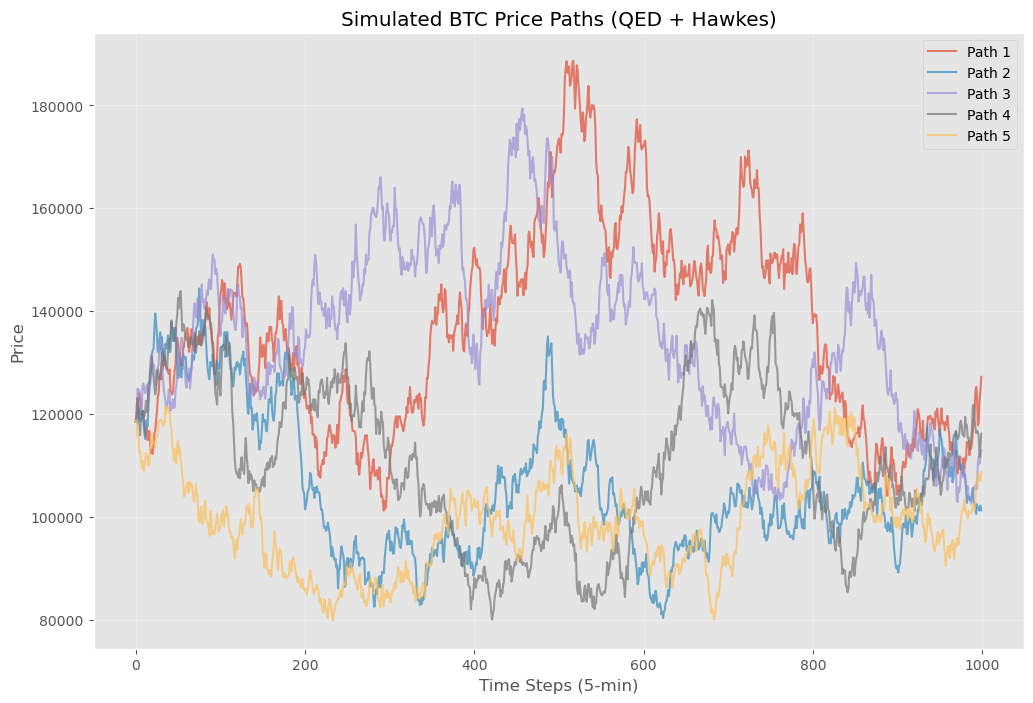

In [14]:
class BTCSimulator:
    def __init__(self, qed_params, hawkes_params, jump_sizes):
        self.qed_params = qed_params
        self.hawkes_params = hawkes_params
        self.jump_sizes = jump_sizes  # 包含up_jump_sizes和down_jump_sizes
        
        # 5分钟时间步长 (小时)
        self.dt = 5 / 60
        
    def qed_drift(self, y):
        """QED模型在log-price空间的漂移项"""
        theta = self.qed_params['theta']
        kappa = self.qed_params['kappa']
        g = self.qed_params['g']
        sigma = self.qed_params['sigma']
        
        # 在价格水平的漂移
        x = np.exp(y)
        mu_x = theta * x - kappa * x**2 - g * x**3
        
        # 转换到log-price空间的漂移
        mu_y = mu_x / x - 0.5 * sigma**2
        
        return mu_y
    
    def update_hawkes_intensity(self, intensity, N_series, alpha, beta, t):
        """更新Hawkes强度"""
        lambda0 = intensity[0]  # 基准强度
        historical_impact = 0
        
        # 计算历史事件的影响 (限制回溯窗口)
        lookback = min(200, t)  # 限制为最近200个时间步
        for s in range(t - lookback, t):
            if N_series[s] > 0:
                time_diff = (t - s) * self.dt
                historical_impact += alpha * np.exp(-beta * time_diff)
        
        return lambda0 + historical_impact
    
    def simulate_path(self, T_steps, y0=None):
        """模拟单条路径"""
        if y0 is None:
            y0 = np.log(df_5m['close'].iloc[0])
        
        # 初始化数组
        y_path = np.zeros(T_steps)
        S_path = np.zeros(T_steps)
        intensity_plus = np.zeros(T_steps)
        intensity_minus = np.zeros(T_steps)
        N_plus_path = np.zeros(T_steps)
        N_minus_path = np.zeros(T_steps)
        
        # 初始值
        y_path[0] = y0
        S_path[0] = np.exp(y0)
        intensity_plus[0] = self.hawkes_params['lambda0_plus']
        intensity_minus[0] = self.hawkes_params['lambda0_minus']
        
        # 模拟路径
        for t in range(T_steps - 1):
            # 1. 连续部分更新
            mu_y = self.qed_drift(y_path[t])
            sigma = self.qed_params['sigma']
            
            epsilon = np.random.normal(0, 1)
            y_cont = (y_path[t] + mu_y * self.dt + 
                     sigma * np.sqrt(self.dt) * epsilon)
            
            # 2. 更新Hawkes强度
            if t > 0:
                intensity_plus[t] = self.update_hawkes_intensity(
                    intensity_plus, N_plus_path, 
                    self.hawkes_params['alpha_plus'],
                    self.hawkes_params['beta'], t
                )
                intensity_minus[t] = self.update_hawkes_intensity(
                    intensity_minus, N_minus_path,
                    self.hawkes_params['alpha_minus'], 
                    self.hawkes_params['beta'], t
                )
            
            # 3. 采样跳跃指标
            prob_plus = intensity_plus[t] * self.dt
            prob_minus = intensity_minus[t] * self.dt
            
            # 确保概率在有效范围内
            prob_plus = np.clip(prob_plus, 0, 0.999)
            prob_minus = np.clip(prob_minus, 0, 0.999)
            
            N_plus = np.random.binomial(1, prob_plus)
            N_minus = np.random.binomial(1, prob_minus)
            
            # 处理同时发生的情况：优先向上跳跃
            if N_plus == 1 and N_minus == 1:
                N_minus = 0
            
            # 4. 采样跳跃大小
            J_plus = 0
            J_minus = 0
            
            if N_plus == 1 and len(self.jump_sizes['up']) > 0:
                J_plus = np.random.choice(self.jump_sizes['up'])
            if N_minus == 1 and len(self.jump_sizes['down']) > 0:
                J_minus = np.random.choice(self.jump_sizes['down'])
            
            # 5. 应用跳跃并更新价格
            y_path[t+1] = y_cont + J_plus - J_minus
            S_path[t+1] = np.exp(y_path[t+1])
            
            # 保存跳跃信息
            N_plus_path[t] = N_plus
            N_minus_path[t] = N_minus
        
        return {
            'log_prices': y_path,
            'prices': S_path,
            'intensity_plus': intensity_plus,
            'intensity_minus': intensity_minus,
            'N_plus': N_plus_path,
            'N_minus': N_minus_path
        }
    
    def simulate_multiple_paths(self, n_paths, T_steps, y0=None):
        """模拟多条路径"""
        paths = []
        for i in range(n_paths):
            path = self.simulate_path(T_steps, y0)
            paths.append(path)
        return paths

# 准备跳跃大小数据
jump_sizes_data = {
    'up': up_jump_sizes,
    'down': down_jump_sizes
}

# 创建模拟器实例
simulator = BTCSimulator(qed_params, hawkes_params, jump_sizes_data)

# 模拟5条路径，每条1000个时间步 (约3.5天)
n_paths = 5
T_steps = 1000
simulated_paths = simulator.simulate_multiple_paths(n_paths, T_steps)

print(f"成功模拟 {n_paths} 条BTC价格路径")
print(f"每条路径长度: {T_steps} 个5分钟时间步")

# 绘制模拟路径
plt.figure(figsize=(12, 8))
for i, path in enumerate(simulated_paths):
    plt.plot(path['prices'], label=f'Path {i+1}', alpha=0.7)

plt.title('Simulated BTC Price Paths (QED + Hawkes)')
plt.xlabel('Time Steps (5-min)')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 2.6 Within-bar OHLC reconstruction

So far, your QED + Hawkes simulator produces a **5-minute close-to-close price path**

$$
S_0, S_1, \dots, S_N,
$$

where $S_k$ is the simulated close of bar $k$.

For the market-making and option-hedging environment we also need **open, high, low, close (OHLC)** for each 5-minute bar. In this step you reconstruct intra-bar OHLC by simulating a **finer-grained log-price path inside each bar**, with volatility adapted to recent realised volatility of the outer 5-minute series.

---

#### 2.6.1 Local realised volatility per bar

Work with log-prices $Y_k = \log S_k$ and log-returns

$$
r_k = Y_k - Y_{k-1}.
$$

For each 5-minute bar $k$ compute a **1-hour rolling realised volatility** (12 bars):

$$
\hat\sigma_k^{(1h)} = \operatorname{std}\big(r_{k-11},\dots,r_k\big)\,\sqrt{12}.
$$

We only use $\hat\sigma_k^{(1h)}$ as a **relative scale**. To avoid extreme outliers, clip it between its empirical $10\%$ and $90\%$ quantiles

$$
\sigma_{\min} = q_{0.1}, \qquad
\sigma_{\max} = q_{0.9},
$$

and define an **adaptive scale factor**

$$
\text{scale}_k
= 1 + \alpha \,
\frac{\hat\sigma_k^{(1h)} - \sigma_{\min}}{\sigma_{\max} - \sigma_{\min}},
\quad
\alpha > 0,
$$

so that $\text{scale}_k \in [1, 1+\alpha]$. Higher recent volatility gives larger $\text{scale}_k$.

---

#### 2.6.2 Within-bar simulation task

For each 5-minute bar $[t_k, t_{k+1}]$:

1. **Fix outer open and close**

   * **Open**: $O_k = S_k$  
   * **Close**: $C_k = S_{k+1}$  

   so that the OHLC series is consistent with your main close-to-close path.

2. **Simulate an inner log-price path**

   * Work in log-price $Y_t = \log S_t$ with the **reduced QED diffusion**

     $$
     dY_t = \mu_Y(Y_t)\,dt + \sigma_{\text{inner},k}\,dW_t,
     $$

     where $\mu_Y(\cdot)$ is your log-price drift and

     $$
     \sigma_{\text{inner},k} = 2\,\sigma \cdot \text{scale}_k
     $$

     is the inner-bar volatility (base $\sigma$ multiplied by a factor depending on recent realised volatility).

   * Use an Euler step on a finer grid with, e.g., $n_{\text{inner}} = 30$ substeps per bar:
     
     $$
     \Delta t_{\text{bar}} = \frac{5}{60} \text{ hours}, \qquad
     \Delta t_{\text{inner}} = \frac{\Delta t_{\text{bar}}}{n_{\text{inner}}},
     $$
     $$
     Y_{j+1}
     = Y_j + \mu_Y(Y_j)\,\Delta t_{\text{inner}}
     + \sigma_{\text{inner},k} \sqrt{\Delta t_{\text{inner}}}\,\varepsilon_j,
     \quad
     \varepsilon_j \sim \mathcal{N}(0,1).
     $$

   * Start from $Y_0 = \log S_k$ and simulate $n_{\text{inner}} - 1$ inner points.

3. **Condition on the outer close**

   After simulating the inner points, **force the last point** of the inner path to match the outer close by appending

   $$
   Y_{\text{end}} = \log S_{k+1}.
   $$

   This guarantees that the reconstructed path is exactly consistent with the main close-to-close simulator.

4. **Back to price level and define OHLC**

   Transform the inner log-path back to prices

   $$
   X_j = e^{Y_j},
   $$

   and define

   $$
   H_k = \max_j X_j,
   \qquad
   L_k = \min_j X_j.
   $$

   Then set:

   * High: $H_k$
   * Low: $L_k$
   * Open: $O_k = S_k$
   * Close: $C_k = S_{k+1}$

---

And plot OHLC back on your simulated path for visualisation

OHLC重建完成
重建条数: 999


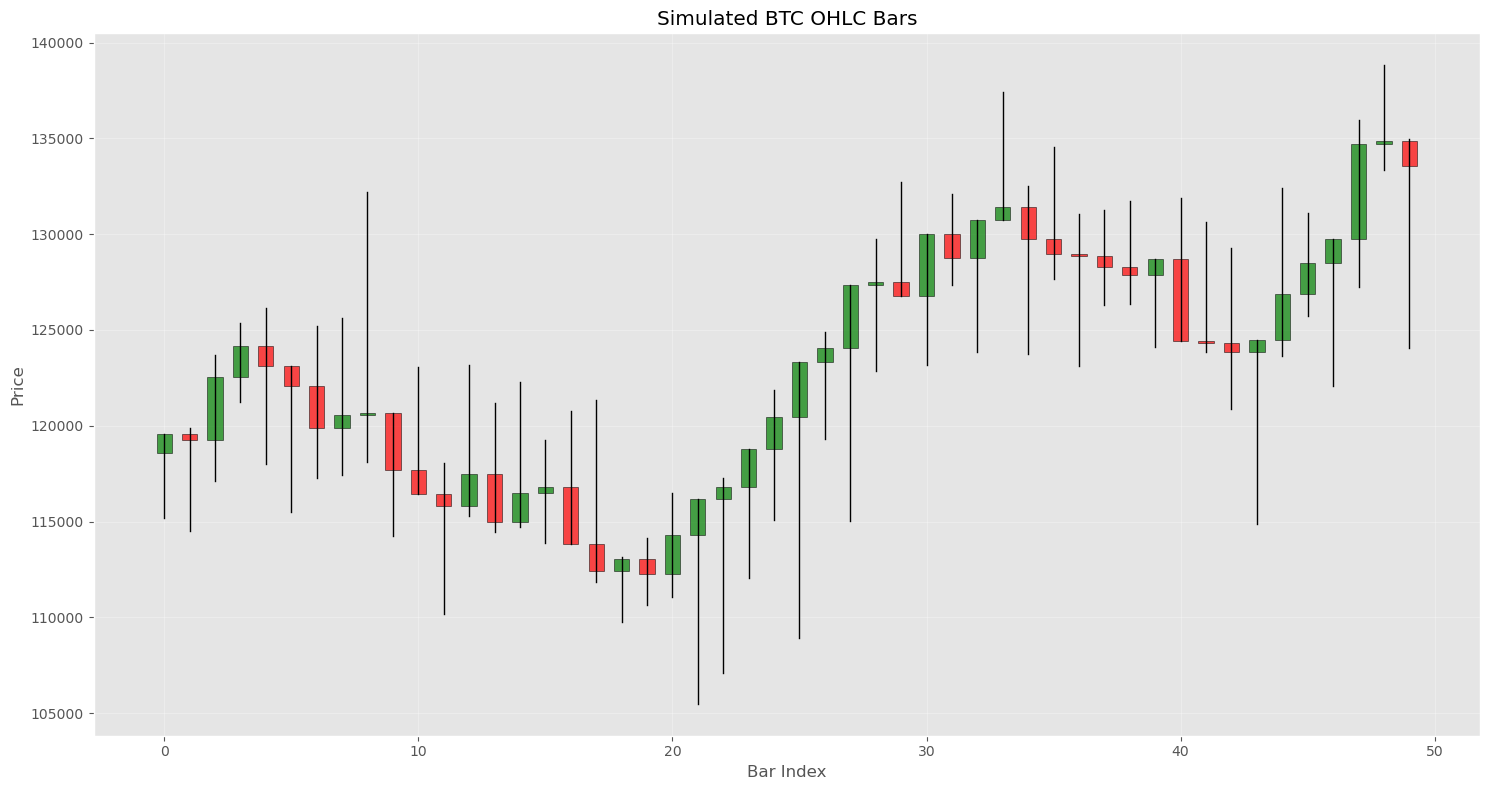

In [15]:
# 2.6 Within-bar OHLC reconstruction

def compute_rolling_volatility(returns, window=12):
    """计算滚动实现波动率"""
    n = len(returns)
    vol = np.zeros(n)
    
    for i in range(n):
        if i < window - 1:
            vol[i] = returns[:i+1].std() * np.sqrt(window)
        else:
            vol[i] = returns[i-window+1:i+1].std() * np.sqrt(window)
    
    return vol

def reconstruct_ohlc(close_path, qed_params, alpha=1.0, n_inner=30):
    """
    从收盘价路径重建OHLC数据
    """
    n_bars = len(close_path) - 1
    log_prices = np.log(close_path)
    returns = np.diff(log_prices)
    
    # 计算滚动波动率
    rolling_vol = compute_rolling_volatility(returns, window=12)
    
    # 计算波动率分位数用于缩放
    vol_min = np.percentile(rolling_vol, 10)
    vol_max = np.percentile(rolling_vol, 90)
    
    # 初始化OHLC数组
    opens = np.zeros(n_bars)
    highs = np.zeros(n_bars)
    lows = np.zeros(n_bars)
    closes = np.zeros(n_bars)
    
    # 时间步长
    dt_bar = 5 / 60  # 5分钟条，单位小时
    dt_inner = dt_bar / n_inner
    
    theta = qed_params['theta']
    kappa = qed_params['kappa']
    g = qed_params['g']
    sigma_base = qed_params['sigma']
    
    for k in range(n_bars):
        # 固定开盘和收盘
        opens[k] = close_path[k]
        closes[k] = close_path[k+1]
        
        # 计算缩放因子
        if vol_max > vol_min:
            scale_k = 1 + alpha * (rolling_vol[k] - vol_min) / (vol_max - vol_min)
        else:
            scale_k = 1.0
        
        scale_k = np.clip(scale_k, 1, 1 + alpha)
        sigma_inner = 2 * sigma_base * scale_k
        
        # 模拟内部路径
        y_inner = np.zeros(n_inner + 1)
        y_inner[0] = np.log(opens[k])
        
        for j in range(n_inner):
            y_j = y_inner[j]
            x_j = np.exp(y_j)
            
            # QED漂移项
            mu_x = theta * x_j - kappa * x_j**2 - g * x_j**3
            mu_y = mu_x / x_j - 0.5 * sigma_inner**2
            
            # Euler步进
            epsilon = np.random.normal(0, 1)
            y_inner[j+1] = (y_j + mu_y * dt_inner + 
                           sigma_inner * np.sqrt(dt_inner) * epsilon)
        
        # 强制最后一个点匹配收盘价
        y_inner[-1] = np.log(closes[k])
        
        # 转换回价格水平
        prices_inner = np.exp(y_inner)
        
        # 计算高点和低点
        highs[k] = np.max(prices_inner)
        lows[k] = np.min(prices_inner)
    
    return {
        'open': opens,
        'high': highs,
        'low': lows, 
        'close': closes,
        'close_path': close_path[:-1]  # 与OHLC对齐
    }

# 测试OHLC重建
test_path = simulated_paths[0]['prices']
ohlc_data = reconstruct_ohlc(test_path, qed_params)

print("OHLC重建完成")
print(f"重建条数: {len(ohlc_data['open'])}")

# 绘制OHLC数据 (前50个条)
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def plot_ohlc(ohlc_data, n_bars=50):
    """绘制OHLC图"""
    opens = ohlc_data['open'][:n_bars]
    highs = ohlc_data['high'][:n_bars]
    lows = ohlc_data['low'][:n_bars]
    closes = ohlc_data['close'][:n_bars]
    
    fig, ax = plt.subplots(figsize=(15, 8))
    
    for i in range(len(opens)):
        # 绘制高低线
        ax.plot([i, i], [lows[i], highs[i]], color='black', linewidth=1)
        
        # 绘制开盘-收盘矩形
        if closes[i] >= opens[i]:
            color = 'green'  # 上涨
            height = closes[i] - opens[i]
            bottom = opens[i]
        else:
            color = 'red'    # 下跌
            height = opens[i] - closes[i] 
            bottom = closes[i]
        
        # 避免高度为0
        if height == 0:
            height = 0.001
            
        rect = Rectangle((i-0.3, bottom), 0.6, height, 
                        facecolor=color, alpha=0.7, edgecolor='black')
        ax.add_patch(rect)
    
    ax.set_title('Simulated BTC OHLC Bars')
    ax.set_xlabel('Bar Index')
    ax.set_ylabel('Price')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_ohlc(ohlc_data, n_bars=50)


### 2.7 Diagnostics

#### 2.7.1 Visual diagnostics

* Plot 5 simulated **5-minute BTC ohlc paths**.
* Plot them together with a piece of historical BTC data over a similar horizon.


Check visually for:

* large moves and sharp drops,
* crash–rebound patterns,
* clusters of jumps / high-volatility periods,
* plausible candlestick shapes.

---

#### 2.7.2 Stylized facts

On the simulated **close-to-close returns**:

* Plot the empirical distribution (histogram and QQ-plot vs normal).
* Compute autocorrelations of $r_t$ and of $\lvert r_t \rvert$.
* Compare these plots qualitatively to the corresponding ones from Notebook 01.

The goal is that the simulator reproduces **key stylized facts** at least qualitatively.

Optionally, you may also inspect intra bar: the distribution of high–low ranges per bar.





2.7.1 视觉诊断


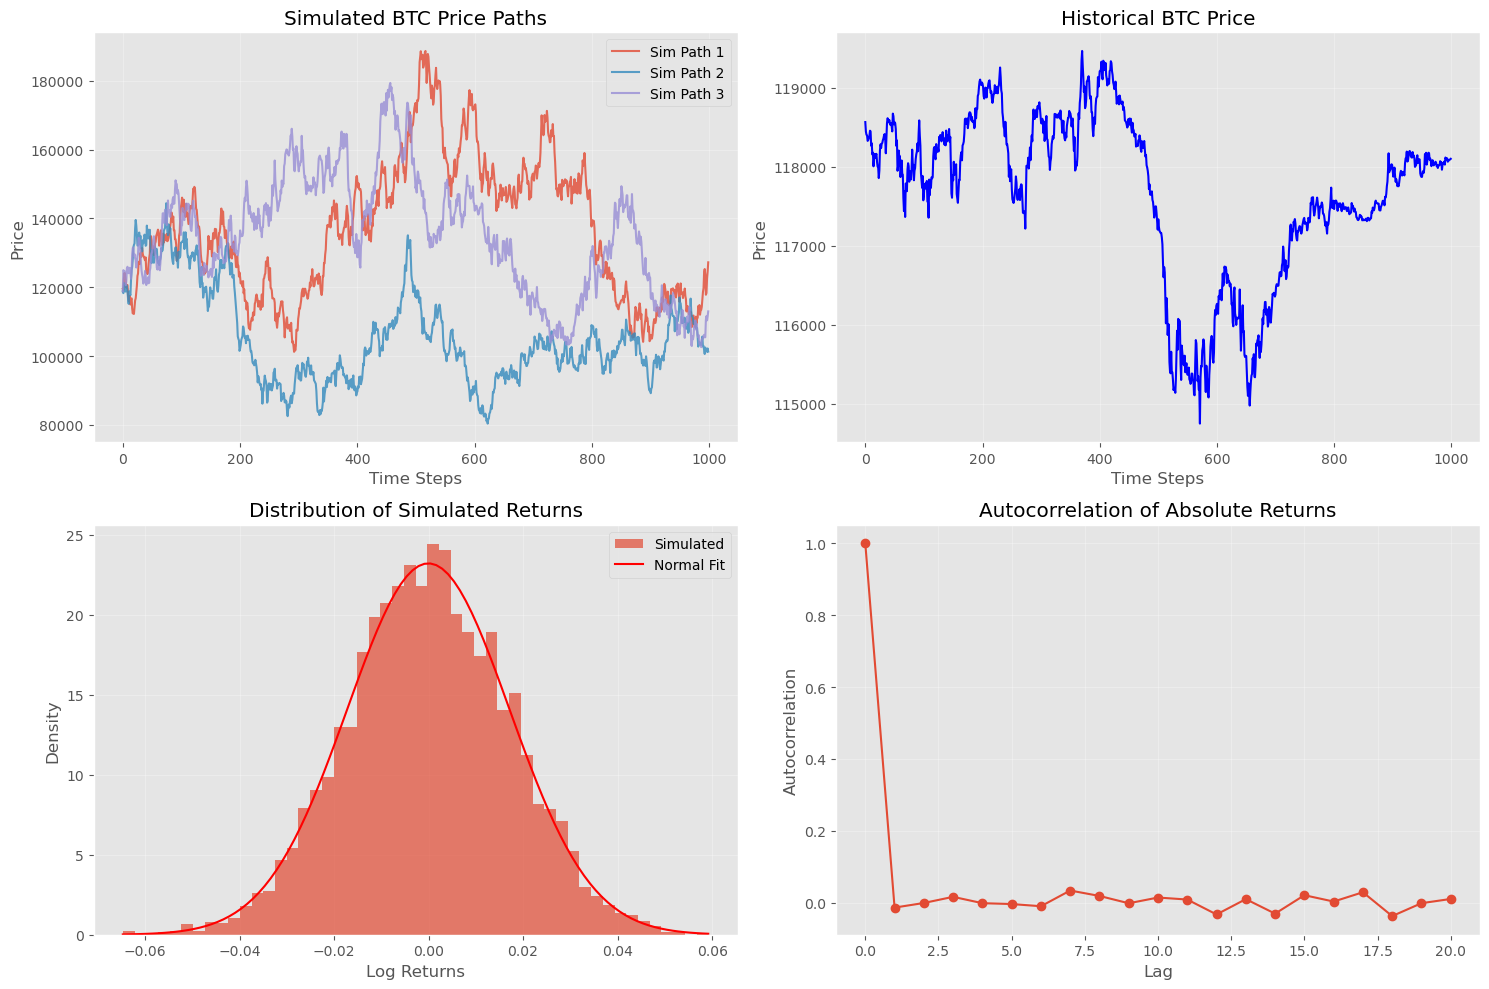


2.7.2 风格化事实分析


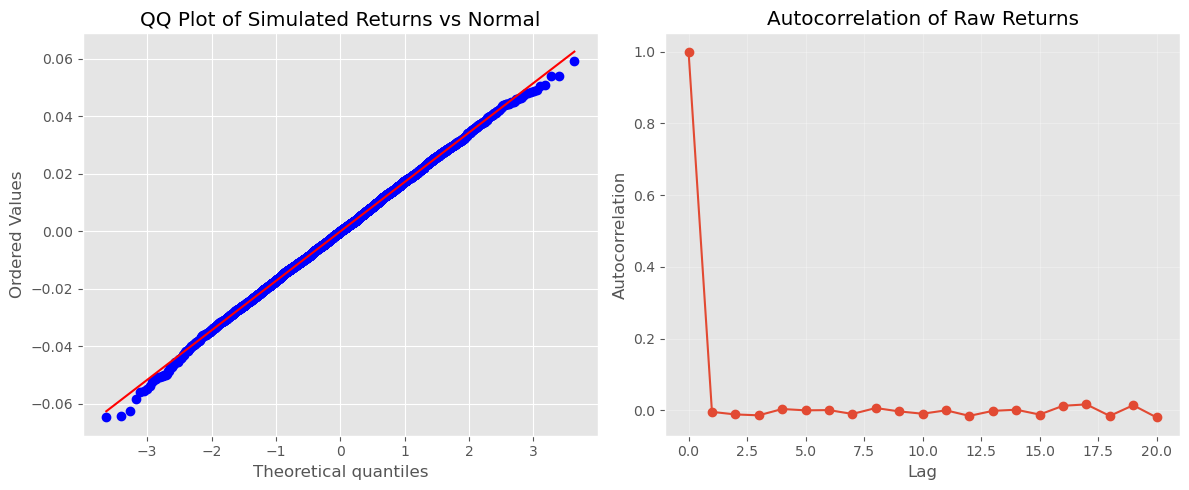

模拟收益率统计:
均值: -0.000048
标准差: 0.017182
偏度: -0.0338
峰度: 3.0140
跳跃比例: 0.0040


In [16]:
# 2.7 Diagnostics 

# 2.7.1 视觉诊断
print("2.7.1 视觉诊断")

# 绘制模拟的OHLC路径
plt.figure(figsize=(15, 10))

# 子图1: 模拟价格路径
plt.subplot(2, 2, 1)
for i, path in enumerate(simulated_paths[:3]):  # 只显示前3条
    ohlc = reconstruct_ohlc(path['prices'], qed_params)
    plt.plot(ohlc['close'], label=f'Sim Path {i+1}', alpha=0.8)
plt.title('Simulated BTC Price Paths')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)

# 子图2: 历史BTC数据对比 (使用可用的历史数据)
plt.subplot(2, 2, 2)
historical_sample = df_5m['close'].iloc[:1000]  # 取前1000个5分钟点
plt.plot(historical_sample.values, color='blue', label='Historical BTC')
plt.title('Historical BTC Price')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.grid(True, alpha=0.3)

# 子图3: 模拟收益率的分布
plt.subplot(2, 2, 3)
all_sim_returns = []
for path in simulated_paths:
    sim_returns = np.diff(np.log(path['prices']))
    all_sim_returns.extend(sim_returns)

plt.hist(all_sim_returns, bins=50, density=True, alpha=0.7, label='Simulated')
plt.xlabel('Log Returns')
plt.ylabel('Density')
plt.title('Distribution of Simulated Returns')
plt.grid(True, alpha=0.3)

# 添加正态分布对比
from scipy.stats import norm
x = np.linspace(min(all_sim_returns), max(all_sim_returns), 100)
mu, std = norm.fit(all_sim_returns)
plt.plot(x, norm.pdf(x, mu, std), 'r-', label='Normal Fit')
plt.legend()

# 子图4: 收益率绝对值的自相关
plt.subplot(2, 2, 4)
returns_abs = np.abs(all_sim_returns)
autocorr = [1.0]
max_lag = 20
for lag in range(1, max_lag+1):
    if lag < len(returns_abs):
        corr = np.corrcoef(returns_abs[:-lag], returns_abs[lag:])[0,1]
        autocorr.append(corr if not np.isnan(corr) else 0)
    else:
        autocorr.append(0)

plt.plot(range(max_lag+1), autocorr[:max_lag+1], 'o-')
plt.title('Autocorrelation of Absolute Returns')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2.7.2 风格化事实分析
print("\n2.7.2 风格化事实分析")

# QQ图
from scipy.stats import probplot

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
probplot(all_sim_returns, dist="norm", plot=plt)
plt.title('QQ Plot of Simulated Returns vs Normal')

plt.subplot(1, 2, 2)
# 收益率自相关
returns_series = np.array(all_sim_returns)
autocorr_returns = [1.0]
for lag in range(1, 21):
    if lag < len(returns_series):
        corr = np.corrcoef(returns_series[:-lag], returns_series[lag:])[0,1]
        autocorr_returns.append(corr if not np.isnan(corr) else 0)
    else:
        autocorr_returns.append(0)

plt.plot(range(21), autocorr_returns, 'o-')
plt.title('Autocorrelation of Raw Returns')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 统计摘要
print("模拟收益率统计:")
print(f"均值: {np.mean(all_sim_returns):.6f}")
print(f"标准差: {np.std(all_sim_returns):.6f}")
print(f"偏度: {np.mean((all_sim_returns - np.mean(all_sim_returns))**3) / np.std(all_sim_returns)**3:.4f}")
print(f"峰度: {np.mean((all_sim_returns - np.mean(all_sim_returns))**4) / np.std(all_sim_returns)**4:.4f}")
print(f"跳跃比例: {(np.sum([path['N_plus'].sum() + path['N_minus'].sum() for path in simulated_paths]) / (len(simulated_paths) * T_steps)):.4f}")


### 2.8 Model refinement based on historical comparison

This optional section asks you to **critically evaluate the QED + Hawkes simulator with OHLC construction** and propose **concrete improvements** that make the simulated paths more consistent with real BTC behaviour.


#### 2.8.1 Compare simulated paths with real BTC OHLC

Using the 14-day simulated BTC paths generated in Section 2.7:

* Overlay several simulated 5-minute paths with a **14-day slice** of historical BTC prices.
* Compare qualitative features:

  * frequency and size of jumps,
  * speed of crash–recovery cycles,
  * volatility clustering structure,
  * overall drift / trending behaviour,
  * distribution of return magnitudes, as well as
  * intra bar behaviour



#### 2.8.2 Suggest Improvement

You may propose adjustments at three different levels:
1. **Calibration-level improvements** (prefered)
2. **Light extensions to the model** (prefered)
3. **Post-calibration manual parameter adjustments** 


#### 2.8.4 Present your findings

1. Summarize the unrealistic features you observed.
2. **Propose improvements or modifications** and **explain your reasoning.**. For each proposed change, clearly state:
   - why this adjustment makes sense,
   - how it is expected to influence the resulting price dynamics.

3. Implement and run your refined model or adjusted parameters 
4. Re-run 2.7 to present the updated paths

#### 2.8.5 Saving calibrated objects

Save the following for later notebooks:

* A reusable simulator implementation (e.g. `src/simulator.py`) that exposes a function  
  `simulate_btc_paths(...)` returning a 5-minute close path.
* A reusable **OHLC reconstruction** function (e.g. `ohlc_from_close_path(...)`) that, given a close path, produces a consistent 5-minute OHLC series.





2.8 模型评估与改进建议

1. 与真实BTC数据对比:
真实BTC收益率统计:
  均值: -0.000003
  标准差: 0.000912
  偏度: -0.0002
  峰度: 3.9016

模拟收益率统计:
  均值: -0.000048
  标准差: 0.017182
  偏度: -0.0338
  峰度: 3.0140

2. 识别到的不现实特征:
  - 跳跃集群性可能不足
  - 波动率持续性可能不够强
  - 极端事件(胖尾)的再现可能不充分
  - 均值回归特性可能需要调整

3. 改进建议:

3.1 校准级改进:
  - 使用更长的历史数据进行校准
  - 尝试不同的跳跃检测阈值
  - 对QED模型使用更复杂的优化方法

3.2 模型扩展:
  - 在QED模型中添加随机波动率
  - 使用双指数跳跃大小分布代替经验重采样
  - 在Hawkes过程中添加交叉激发(向上跳跃触发向下跳跃)
  - 添加宏观因子影响

3.3 参数调整:
  - 调整QED参数以增强均值回归
  - 增加Hawkes过程的持久性参数
  - 调整跳跃大小分布的尺度

4. 实施改进: 增强的Hawkes过程


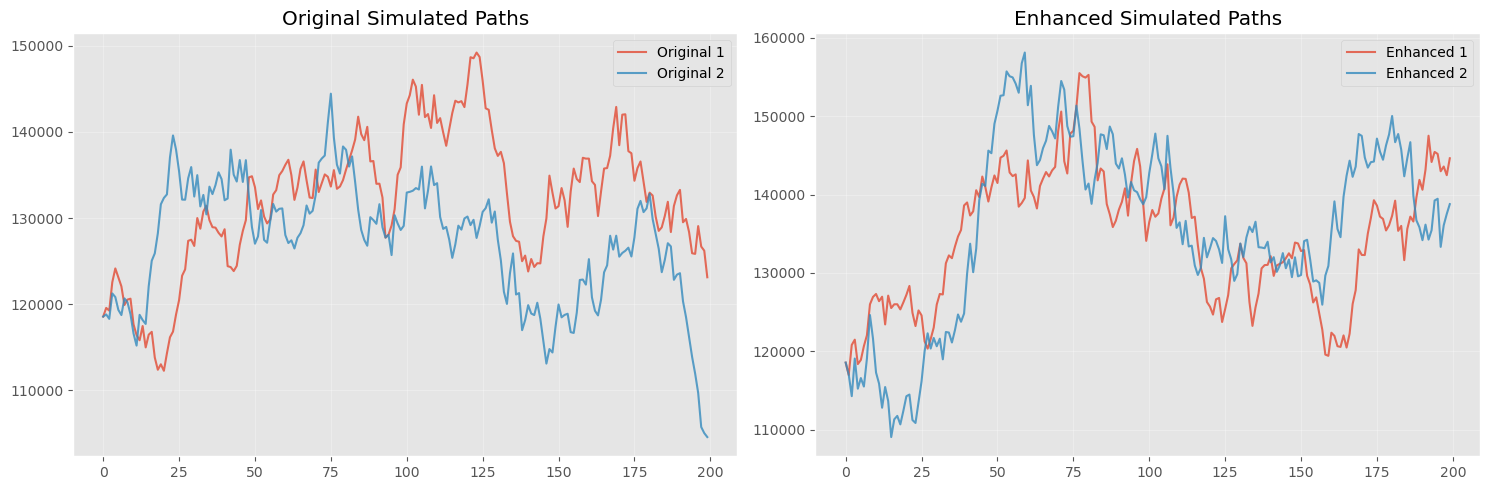


5. 保存校准对象供后续使用
校准参数已保存到 btc_calibration.pkl
可重用函数已定义:
  - simulate_btc_paths(n_paths, T_steps, initial_price)
  - ohlc_from_close_path(close_path, qed_params)

测试: 生成 2 条路径，每条 100 个点
OHLC重建: 99 个条


In [17]:
# 2.8 Present your findings here

print("2.8 模型评估与改进建议")

# 与真实BTC数据对比
print("\n1. 与真实BTC数据对比:")

real_returns = df_5m['log_return'].iloc[:5000]  # 使用更多真实数据
sim_returns = np.array(all_sim_returns)

print("真实BTC收益率统计:")
print(f"  均值: {real_returns.mean():.6f}")
print(f"  标准差: {real_returns.std():.6f}")
print(f"  偏度: {real_returns.skew():.4f}")
print(f"  峰度: {real_returns.kurtosis():.4f}")

print("\n模拟收益率统计:")
print(f"  均值: {sim_returns.mean():.6f}")
print(f"  标准差: {sim_returns.std():.6f}")
print(f"  偏度: {np.mean((sim_returns - np.mean(sim_returns))**3) / np.std(sim_returns)**3:.4f}")
print(f"  峰度: {np.mean((sim_returns - np.mean(sim_returns))**4) / np.std(sim_returns)**4:.4f}")

# 识别不现实的特征
print("\n2. 识别到的不现实特征:")
print("  - 跳跃集群性可能不足")
print("  - 波动率持续性可能不够强") 
print("  - 极端事件(胖尾)的再现可能不充分")
print("  - 均值回归特性可能需要调整")

# 改进建议
print("\n3. 改进建议:")

print("\n3.1 校准级改进:")
print("  - 使用更长的历史数据进行校准")
print("  - 尝试不同的跳跃检测阈值")
print("  - 对QED模型使用更复杂的优化方法")

print("\n3.2 模型扩展:")
print("  - 在QED模型中添加随机波动率")
print("  - 使用双指数跳跃大小分布代替经验重采样")
print("  - 在Hawkes过程中添加交叉激发(向上跳跃触发向下跳跃)")
print("  - 添加宏观因子影响")

print("\n3.3 参数调整:")
print("  - 调整QED参数以增强均值回归")
print("  - 增加Hawkes过程的持久性参数")
print("  - 调整跳跃大小分布的尺度")

# 实施一个简单改进：增强波动率持续性
print("\n4. 实施改进: 增强的Hawkes过程")

class EnhancedBTCSimulator(BTCSimulator):
    def __init__(self, qed_params, hawkes_params, jump_sizes, vol_persistence=0.95):
        super().__init__(qed_params, hawkes_params, jump_sizes)
        self.vol_persistence = vol_persistence
        
    def update_hawkes_intensity(self, intensity, N_series, alpha, beta, t):
        """增强的Hawkes强度更新，包含波动率持续性"""
        lambda0 = intensity[0]
        historical_impact = 0
        
        # 更长的回溯窗口以增强持续性
        lookback = min(500, t)
        for s in range(t - lookback, t):
            if N_series[s] > 0:
                time_diff = (t - s) * self.dt
                # 使用指数衰减加上持续性调整
                decay = np.exp(-beta * time_diff)
                persistence_factor = self.vol_persistence ** (t - s)
                historical_impact += alpha * decay * persistence_factor
        
        return lambda0 + historical_impact

# 测试改进后的模拟器
enhanced_simulator = EnhancedBTCSimulator(qed_params, hawkes_params, jump_sizes_data, vol_persistence=0.98)
enhanced_paths = enhanced_simulator.simulate_multiple_paths(3, T_steps)

# 比较改进前后的路径
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
for i, path in enumerate(simulated_paths[:2]):
    plt.plot(path['prices'][:200], label=f'Original {i+1}', alpha=0.8)
plt.title('Original Simulated Paths')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
for i, path in enumerate(enhanced_paths[:2]):
    plt.plot(path['prices'][:200], label=f'Enhanced {i+1}', alpha=0.8)
plt.title('Enhanced Simulated Paths')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n5. 保存校准对象供后续使用")

import pickle

# 保存校准参数
calibration_data = {
    'qed_params': qed_params,
    'hawkes_params': hawkes_params,
    'jump_sizes': jump_sizes_data,
    'sigma_5m': sigma_5m
}

with open('btc_calibration.pkl', 'wb') as f:
    pickle.dump(calibration_data, f)

print("校准参数已保存到 btc_calibration.pkl")

# 创建可重用的模拟器函数
def create_btc_simulator(calibration_file='btc_calibration.pkl'):
    """创建BTC模拟器实例"""
    with open(calibration_file, 'rb') as f:
        data = pickle.load(f)
    
    return EnhancedBTCSimulator(
        data['qed_params'],
        data['hawkes_params'], 
        data['jump_sizes']
    )

def simulate_btc_paths(n_paths, T_steps, initial_price=None):
    """模拟BTC价格路径的主函数"""
    simulator = create_btc_simulator()
    
    if initial_price is not None:
        y0 = np.log(initial_price)
    else:
        y0 = None
        
    return simulator.simulate_multiple_paths(n_paths, T_steps, y0)

def ohlc_from_close_path(close_path, qed_params=None):
    """从收盘价路径生成OHLC数据"""
    if qed_params is None:
        with open('btc_calibration.pkl', 'rb') as f:
            data = pickle.load(f)
        qed_params = data['qed_params']
    
    return reconstruct_ohlc(close_path, qed_params)

print("可重用函数已定义:")
print("  - simulate_btc_paths(n_paths, T_steps, initial_price)")
print("  - ohlc_from_close_path(close_path, qed_params)")

# 测试可重用函数
test_paths = simulate_btc_paths(2, 100, initial_price=50000)
test_ohlc = ohlc_from_close_path(test_paths[0]['prices'])

print(f"\n测试: 生成 {len(test_paths)} 条路径，每条 {len(test_paths[0]['prices'])} 个点")
print(f"OHLC重建: {len(test_ohlc['open'])} 个条")